In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_step
%store -r Y_motion_step
print(X_motion_step.shape)
print(Y_motion_step.shape)

(148884, 38)
(148884, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL foot is swinging
idx_fr_swinging = np.where(X_motion_step[:, 24] == 1)[0]
X_motion_step_FR = X_motion_step[idx_fr_swinging]
Y_motion_step_FR = Y_motion_step[idx_fr_swinging]

In [17]:
for x in range(100):
    DT = 0
    x_velocity = None
    y_velocity = None
    
    if x == 0:
        x_velocity = 0
        y_velocity = 0
    else:
        DT = X_motion_step[idx_fr_swinging[x]+1, -1] - X_motion_step[idx_fr_swinging[x], -1]
        x_velocity = X_motion_step[idx_fr_swinging[x]-1, 28] / DT
        y_velocity = X_motion_step[idx_fr_swinging[x]-1, 29] / DT
                                  
    print(f'Command: {X_motion_step[x, 0]}. FR step: {X_motion_step[idx_fr_swinging[x]-1, 28]}. DT: {DT}. FL velocity (x): {x_velocity}. FL velocity (y): {y_velocity}')

Command: 0.1. FR step: 0.0. DT: 0. FL velocity (x): 0. FL velocity (y): 0
Command: 0.1. FR step: 0.0. DT: 0.34110283851623535. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.1. FR step: 0.0. DT: 0.3515498638153076. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.1. FR step: 0.0. DT: 0.34302186965942383. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.1. FR step: 0.0. DT: 0.3473803997039795. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.1. FR step: 0.0. DT: 0.30436182022094727. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.1. FR step: 0.0. DT: 0.3015124797821045. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.1. FR step: 0.0. DT: 0.29698681831359863. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.1. FR step: 0.0. DT: 0.34815049171447754. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.15000000000000002. FR step: 0.0. DT: 0.2709662914276123. FL velocity (x): 0.0. FL velocity (y): 0.0
Command: 0.15000000000000002. FR step: 0.0. DT: 0.

## Predict FR foot -> x

In [8]:
X_motion_step_FR[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.73259492e-08,  8.26137569e-09,
       -2.31107939e-43,  2.55124842e-26, -1.29773315e-23,  4.71751457e-03,
        1.56884253e-01,  1.33104801e-01, -3.39981973e-01,  1.92550018e-01,
       -1.40392303e-01, -3.33698064e-01, -2.76241094e-01,  1.40536815e-01,
       -3.36472392e-01, -2.58489013e-01, -1.30886346e-01, -3.38354051e-01,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.23098426e-02, -4.47599696e-03,
        1.79496527e-01])

In [9]:
Y_motion_step_FR[0, :]

array([ 0.        ,  0.        ,  0.01586381, -0.00457941,  0.02445424,
        0.00146174,  0.        ,  0.        ])

In [10]:
Y_motion_step_FR.shape

(75769, 8)

In [11]:
#X_motion_step[idx_fr_swinging - 1, 28]

In [14]:
X_motion_step[idx_fr_swinging-1, 28][:100]

array([0.        , 0.01586381, 0.05948897, 0.05894744, 0.06044418,
       0.05375968, 0.08509007, 0.09557687, 0.08357988, 0.08905752,
       0.06752773, 0.0539757 , 0.05394599, 0.05371091, 0.06225052,
       0.08551434, 0.08430591, 0.0873313 , 0.09798636, 0.07999153,
       0.05351496, 0.05294903, 0.05853119, 0.0593307 , 0.07618429,
       0.08299088, 0.09193519, 0.08785801, 0.09536757, 0.05154957,
       0.05384161, 0.05923106, 0.05963865, 0.0727966 , 0.08515976,
       0.09435426, 0.09515874, 0.09133466, 0.05867429, 0.05787624,
       0.06208937, 0.05323771, 0.07313876, 0.09763171, 0.0846561 ,
       0.08953345, 0.09247576, 0.06921554, 0.05526379, 0.05275954,
       0.05385101, 0.05491464, 0.09687513, 0.08376804, 0.097821  ,
       0.09351549, 0.07900506, 0.05383775, 0.05693512, 0.05602419,
       0.05551869, 0.08844931, 0.09460618, 0.08604218, 0.08642529,
       0.07473938, 0.06017241, 0.05349304, 0.05387045, 0.05546698,
       0.07648577, 0.08558086, 0.08330077, 0.08445747, 0.09596

In [15]:
X_motion_step[idx_fr_swinging, 26][:100]

array([0.        , 0.07464571, 0.06010439, 0.06078163, 0.05450465,
       0.06848326, 0.09516867, 0.08363788, 0.0862579 , 0.08774815,
       0.052808  , 0.0544083 , 0.05372943, 0.06195404, 0.0687784 ,
       0.08469264, 0.08332793, 0.09989096, 0.09243038, 0.05933575,
       0.05358246, 0.05847915, 0.05842283, 0.05954041, 0.08378454,
       0.09065428, 0.08591603, 0.0970754 , 0.07003787, 0.05217314,
       0.05968502, 0.06025758, 0.05286194, 0.08810744, 0.09398463,
       0.0959523 , 0.08868574, 0.07720284, 0.05756426, 0.0624297 ,
       0.05377547, 0.0603686 , 0.09169602, 0.08689214, 0.08928135,
       0.09183738, 0.08717282, 0.05301684, 0.05561276, 0.0527551 ,
       0.05350466, 0.08151005, 0.08473858, 0.09451021, 0.09218401,
       0.09860574, 0.05418505, 0.05793175, 0.05589502, 0.05422227,
       0.06791385, 0.09737831, 0.08854353, 0.0855709 , 0.08459334,
       0.06744415, 0.05369668, 0.05349596, 0.05405936, 0.06009391,
       0.08743665, 0.08254763, 0.08471991, 0.09536809, 0.07636

### Linear Regression

In [34]:
# Input
#X = np.hstack((X_motion_step_FR[:, :2], np.array([X_motion_step_FR[:, 5]]).T, 
#               X_motion_step_FR[:, 6:8], np.array([X_motion_step_FR[:, 11]]).T, 
#               np.array([X_motion_step_FR[:, 12]]).T, np.array([X_motion_step_FR[:, 15]]).T))
X = np.hstack((X_motion_step_FR[:, :2], np.array([X_motion_step_FR[:, 5]]).T, 
               np.array([X_motion_step_FR[:, 12]]).T, np.array([X_motion_step_FR[:, 15]]).T))

X = np.hstack((X_motion_step_FR[:, :2], 
               np.array([X_motion_step_FR[:, 5]]).T,
               np.array([X_motion_step[idx_fr_swinging-1, 28]]).T, 
               np.array([X_motion_step[idx_fr_swinging, 26]]).T,
               X_motion_step[idx_fr_swinging, 34:36]))

# Labels
Y = np.array([Y_motion_step_FR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_fr_x = LinearRegression()

# Fit the model
model_fr_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9762935932083614
RMSE:  0.014999521364366676
The lowest error is:  5.159992861325513e-07
The highest error is:  0.1707325087399046
The avg. error is:  0.008819528555203654


Text(0, 0.5, 'Predictions')

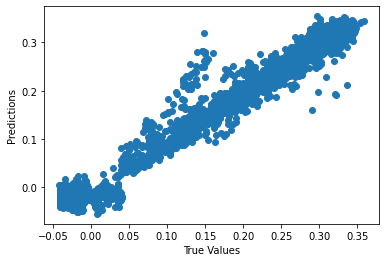

In [35]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [36]:
%store model_fr_x

Stored 'model_fr_x' (LinearRegression)


In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
joblib.dump(model_fr_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_x.sav']

## Predict FR foot -> y

### Linear Regression

In [37]:
# Input
#X = np.hstack((X_motion_step_FR[:, :2], np.array([X_motion_step_FR[:, 5]]).T, 
#               X_motion_step_FR[:, 6:8], np.array([X_motion_step_FR[:, 11]]).T, 
#               np.array([X_motion_step_FR[:, 13]]).T, np.array([X_motion_step_FR[:, 16]]).T))
X = np.hstack((X_motion_step_FR[:, :2], np.array([X_motion_step_FR[:, 5]]).T, 
               np.array([X_motion_step_FR[:, 13]]).T, np.array([X_motion_step_FR[:, 16]]).T))

X = np.hstack((X_motion_step_FR[:, :2], 
               np.array([X_motion_step_FR[:, 5]]).T,
               np.array([X_motion_step[idx_fr_swinging-1, 29]]).T, 
               np.array([X_motion_step[idx_fr_swinging, 27]]).T,
               X_motion_step[idx_fr_swinging, 34:36]))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motion_step_FR[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_fr_y = LinearRegression()

# Fit the model
model_fr_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9873787479873498
RMSE:  0.011302806538883685
The lowest error is:  2.4363147106166994e-07
The highest error is:  0.09387039364498909
The avg. error is:  0.008206536628153254


Text(0, 0.5, 'Predictions')

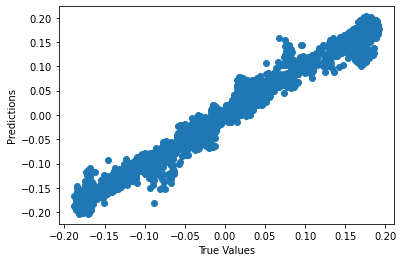

In [38]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [39]:
%store model_fr_y

Stored 'model_fr_y' (LinearRegression)


In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [21]:
# Save model
joblib.dump(model_fr_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_y.sav']